In [442]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from pandas.plotting import table 

import seaborn as sns


First, fit model to stocks response (either Chinese or American), with each dataset individually. Find the best performing dataset.

In [3]:
txt = open('stocks_model_performance.1.txt', 'r')
lines = txt.readlines()

In [470]:
def get_model_data(line):
    d = json.loads(line.strip("\n").replace("'", '"'))
    # report model name, predictor set, predictor lookback, response set, dropout, classifier or regressor
    return([d['model_name'], 
            d['predictors'][0][0], 
            d['predictors'][0][1], 
            d['response']['fname'], 
            d['model_params']['dropout_pct'],
            d['model_params']['model_type'],
            d['training_params']['epochs'],
            d['model_params']['n_layers'],
            d['model_params']['nodes_per_layer'],
            d['augment']['n'],
            d['augment']['stdev']])

def get_performance(line, model_type):

    line = line.rstrip()
    if model_type == 'classifier':
        auc = float(re.search(r"AUC (?P<auc>[-+]?[0-9]*\.?[0-9]+),", line).group('auc'))
        return([auc])
    else:
        print(line)
        tstat = float(re.search(r"tstat (?P<val>[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?)", line).group('val'))
        pval = float(re.search(r"pval (?P<val>[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?)", line).group('val'))
        training_loss = float(re.search(r"training_loss (?P<val>[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?),", line).group('val'))
        validation_loss = float(re.search(r"validation_loss (?P<val>[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?),", line).group('val'))
        test_loss = float(re.search(r"test_loss (?P<val>[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?),", line).group('val'))
        random5pc_loss = float(re.search(r"random5pc_loss (?P<val>[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?),", line).group('val'))
        random_mean = float(re.search(r"random_mean (?P<val>[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?),", line).group('val'))
        random95pc_loss =  float(re.search(r"random95pc_loss (?P<val>[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?)", line).group('val'))
        return([tstat, pval, training_loss, validation_loss, test_loss, random5pc_loss, random_mean, random95pc_loss])
    
def get_model_performance(lines):
    classifiers = []
    regressors = []
    i = 0
    while True:
        if i == len(lines):
            break
        if "model_name" in lines[i]:
            model_data = get_model_data(lines[i])
            
            if "Performance" in lines[i+1]:
                performance = get_performance(lines[i+1], model_data[5])
    
                model_info = model_data + performance
                if model_data[-1] == 'classifier':
                    classifiers.append(model_info)
                else:
                    regressors.append(model_info)
                i += 2
            else:
                i += 1
        else:
            print(i)
            print("End or mistake")
            print(lines[i])
            i += 1

    model_cols = ["model_name", "predictor_set", "predictor_lookback", "response_set", "dropout", "model_type", "epochs", "n_layers", "nodes_per_layer", "augment_n", "augment_stdev"] 

    if len(classifiers) > 0:
        classifier_cols = ["auc"]
        classifiers_df = pd.DataFrame(classifiers)
        classifiers_df.columns = model_cols + classifier_cols
    else:
        classifiers_df = None
        
    if len(regressors) > 0:
        regressor_cols = ["tstat", "pval", "training_loss", "validation_loss", "test_loss", "random5pc_loss", "random_mean", "random95pc_loss"]
        regressors_df = pd.DataFrame(regressors)
        regressors_df.columns = model_cols + regressor_cols
    else:
        regressors_df = None

    return(classifiers_df, regressors_df)

def get_regressor_violin(df):
    df['pct_improvement'] = (1 - df.test_loss/df.random_mean)*100    
    
    gby = df.groupby('predictor_set')
    grouped_improvement = [i[1]['pct_improvement'] for i in gby ]
   
   
    plot = sns.violinplot(x='predictor_set', y='pct_improvement', data=df)
    plot.set_xticklabels([str(x).split("/")[-1].split(".")[0] for x in plot.get_xticklabels()], rotation=90)

    #plot.set_xticklabels([""] + [str(x[0]).split("/")[-1].split(".")[0] for x in gby], rotation=90)
    return(df, plot)

605
End or mistake
Previously run

607
End or mistake
Previously run



    model_name                                      predictor_set  \
7    model_110                ../tweets/data/sentiment.by_day.csv   
133   model_96                ../tweets/data/sentiment.by_day.csv   
125   model_54  ../tweets/data/word2vec_doc_embeddings.by_date...   
3    model_102                ../tweets/data/sentiment.by_day.csv   
43     model_2  ../tweets/data/keyword_word2vec_predictors.by_...   

     predictor_lookback                     response_set  dropout  model_type  \
7                     3  ../stocks/amer_stocks_delta.csv      0.3  classifier   
133                   0  ../stocks/amer_stocks_delta.csv      0.0  classifier   
125                   1  ../stocks/amer_stocks_delta.csv      0.0  classifier   
3                     1  ../stocks/amer_stocks_delta.csv      0.0  classifier   
43                    0  ../stocks/amer_stocks_delta.csv      0.3  classifier   

          auc  
7    0.611253  
133  0.592340  
125  0.580217  
3    0.572766  
43   0.570213  
..

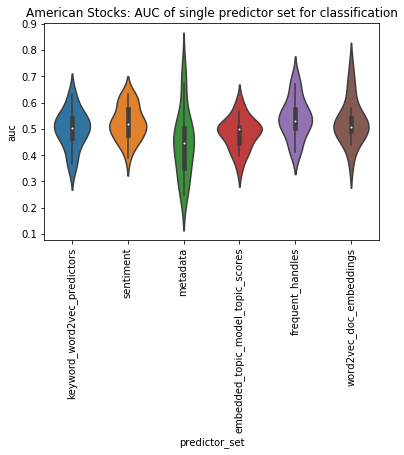

In [199]:
print(classifiers_df[classifiers_df.response_set == '../stocks/amer_stocks_delta.csv'].sort_values('auc', ascending=False).head())
for i in classifiers_df[classifiers_df.response_set == '../stocks/amer_stocks_delta.csv'].groupby('predictor_set'):
    print(i[0], i[1]['auc'])
df = classifiers_df[classifiers_df.response_set == '../stocks/amer_stocks_delta.csv']
df = df[df.dropout == 0.3]

#plot = sns.barplot(x='predictor_set', y='auc', hue='predictor_lookback', data=df)
#plot.set_xticklabels([str(x).split("/")[-1].split(".")[0] for x in plot.get_xticklabels()], rotation=90)
#plt.savefig("AUC_classification_model_individual_datasets.png", h=5, w=15)

plot = sns.violinplot(x='predictor_set', y='auc', data=classifiers_df)
plot.set_xticklabels([str(x).split("/")[-1].split(".")[0] for x in plot.get_xticklabels()], rotation=90)
plot.set_title('American Stocks: AUC of single predictor set for classification')
plt.savefig('../../assets/img/american_stocks_1.single_predictor_set.classifier_auc.png')

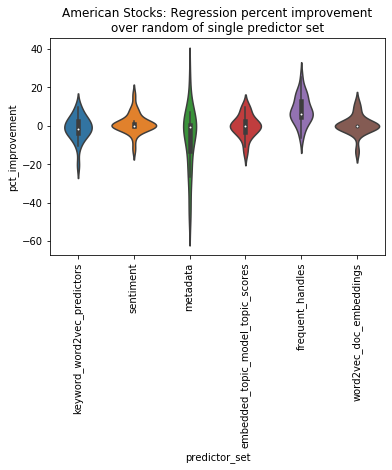

In [198]:
regressors_df[regressors_df.response_set == '../stocks/amer_stocks_delta.csv'].sort_values('tstat', ascending=False)
df, plot = get_regressor_violin(regressors_df)
plot.set_title('American Stocks: Regression percent improvement\nover random of single predictor set')
plt.savefig('../../assets/img/american_stocks_1.single_predictor_set.regressor_pct_improvement.png')

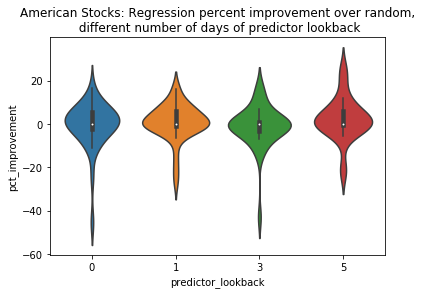

In [207]:
# look at american stock lookback
plot = sns.violinplot(x='predictor_lookback', y='pct_improvement', data=regressors_df)
plot.set_title('American Stocks: Regression percent improvement over random,\n different number of days of predictor lookback')
plt.savefig('../../assets/img/american_stocks_1.single_predictor_set.lookback_improvement.png')


In [458]:
txt = open('chinese_stocks_1.txt', 'r')
lines = txt.readlines()
classifiers, regressors = get_model_performance(lines)
classifiers.sort_values('auc', ascending=False).head(n=20)

plot = sns.violinplot(x='predictor_set', y='auc', data=classifiers)
plot.set_xticklabels([str(x).split("/")[-1].split(".")[0] for x in plot.get_xticklabels()], rotation=90)
plot.set_title('Chinese Stocks: AUC of single predictor set for classification')
plt.savefig('../../assets/img/chinese_stocks_1.single_predictor_set.classifier_auc.png')


Performance: tstat 26.895023290415235, pval 2.6250108550397444e-47, training_loss 0.006529659647271118, validation_loss 0.021451480112806832, test_loss 0.5345123642956832, random5pc_loss 0.5613773920089533, random_mean 0.6131946828613853, random95pc_loss 0.6666181394994891
Performance: tstat 19.497191411499, pval 1.1303240930142128e-35, training_loss 0.233384819821157, validation_loss 0.09234595640908555, test_loss 0.4520688975236441, random5pc_loss 0.4619127221326525, random_mean 0.49819172337493284, random95pc_loss 0.5411334920266492
Performance: tstat 24.15853200599682, pval 2.678812103870279e-43, training_loss 0.43287239989901577, validation_loss 0.2507281699498482, test_loss 0.31134029677920966, random5pc_loss 0.32238061036322224, random_mean 0.3561092837533975, random95pc_loss 0.38614145226697616
Performance: tstat 11.591648518527649, pval 3.8533533105347606e-20, training_loss 0.002145741256121485, validation_loss 0.004727902425803146, test_loss 0.47910442237508594, random5pc_los

AttributeError: 'NoneType' object has no attribute 'sort_values'

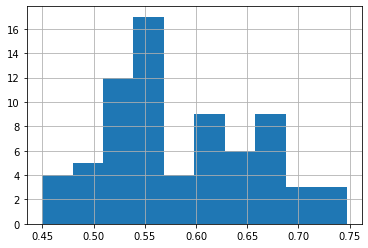

In [268]:
classifiers['auc'].hist()

,model_name,predictor_set,predictor_lookback,response_set,dropout,model_type,epochs,n_layers,nodes_per_layer,augment_n,tstat,pval,training_loss,validation_loss,test_loss,random5pc_loss,random_mean,random95pc_loss,pct_improvement
45,model_237,../tweets/data/frequent_handles.by_day.csv,5,../stocks/log_adj_chinese_combo.csv,0.3,regressor,100,3,32,50,68.490219,3.274973e-85,0.315401,0.275513,0.262563,0.398513,0.431604,0.474862,39.165811
47,model_239,../tweets/data/frequent_handles.by_day.csv,5,../stocks/log_adj_chinese_combo.csv,0.5,regressor,100,3,32,50,63.799520,3.151738e-82,0.520430,0.435684,0.300642,0.416243,0.457599,0.495444,34.300085
41,model_233,../tweets/data/frequent_handles.by_day.csv,3,../stocks/log_adj_chinese_combo.csv,0.5,regressor,100,3,32,50,63.508961,4.899742e-82,0.622955,0.572809,0.294914,0.390585,0.421561,0.459501,30.042314
39,model_231,../tweets/data/frequent_handles.by_day.csv,3,../stocks/log_adj_chinese_combo.csv,0.3,regressor,100,3,32,50,54.576883,1.064560e-75,0.445120,0.438816,0.368870,0.469087,0.518962,0.565466,28.921520
35,model_227,../tweets/data/frequent_handles.by_day.csv,1,../stocks/log_adj_chinese_combo.csv,0.5,regressor,100,3,32,50,44.379983,3.728990e-67,0.717535,0.703319,0.269981,0.333305,0.366609,0.404601,26.357271
119,model_335,../tweets/data/metadata.by_day.csv,5,../stocks/log_adj_chinese_combo.csv,0.5,regressor,100,3,32,50,49.413911,1.412339e-71,0.533282,0.489139,0.229313,0.279501,0.304024,0.330082,24.573977
27,model_219,../tweets/data/frequent_handles.by_day.csv,0,../stocks/log_adj_chinese_combo.csv,0.3,regressor,100,3,32,50,39.758691,1.122626e-62,0.692129,0.703559,0.314857,0.371083,0.406695,0.449090,22.581431
29,model_221,../tweets/data/frequent_handles.by_day.csv,0,../stocks/log_adj_chinese_combo.csv,0.5,regressor,100,3,32,50,39.471143,2.207921e-62,0.759497,0.764332,0.239664,0.286254,0.309064,0.340519,22.454822
113,model_329,../tweets/data/metadata.by_day.csv,3,../stocks/log_adj_chinese_combo.csv,0.5,regressor,100,3,32,50,52.595629,3.668836e-74,0.604977,0.576565,0.220570,0.261500,0.279963,0.301208,21.214559
33,model_225,../tweets/data/frequent_handles.by_day.csv,1,../stocks/log_adj_chinese_combo.csv,0.3,regressor,100,3,32,50,31.061945,7.538256e-53,0.597740,0.598237,0.472645,0.517208,0.586912,0.648096,19.469170


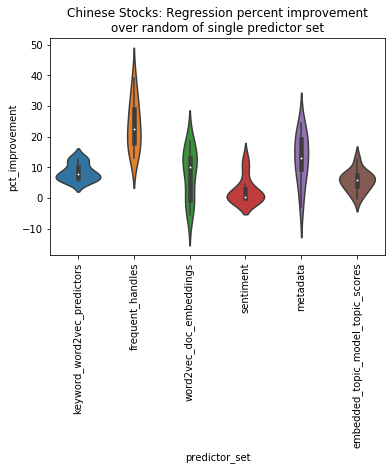

In [460]:
#chinese stock regression
df, plot = get_regressor_violin(regressors)
plot.set_title('Chinese Stocks: Regression percent improvement\nover random of single predictor set')

plt.savefig('../../assets/img/chinese_stocks_1.single_predictor_set.regressor_pct_improvement.png')
df.sort_values('pct_improvement', ascending=False).head(n=20)




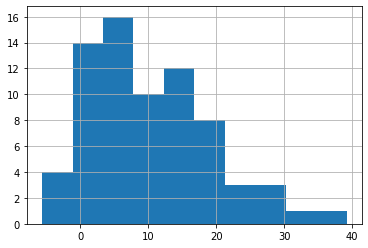

In [261]:
df['pct_improvement'].hist()

In [ ]:
df.sort_values('pct_improvement', ascending=False).head(n=20)


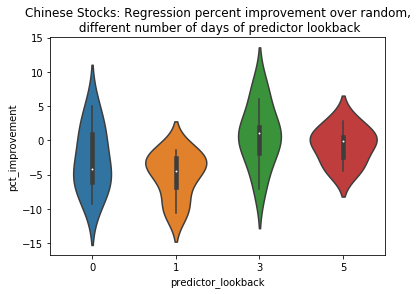

In [206]:
# consider lookback and percent improvement
plot = sns.violinplot(x='predictor_lookback', y='pct_improvement', data=df)
plot.set_title('Chinese Stocks: Regression percent improvement over random,\n different number of days of predictor lookback')
plt.savefig('../../assets/img/chinese_stocks_1.single_predictor_set.lookback_improvement.png')


Currencies now

,model_name,predictor_set,predictor_lookback,response_set,dropout,model_type,tstat,pval,test_loss,random5pc_loss,random_mean,random95pc_loss,pct_improvement
87,model_603,../tweets/data/word2vec_doc_embeddings.by_date...,1,../miscdata/usd_rub_exchangerate.delta.csv,0.0,regressor,22.966770,1.891753e-41,0.219874,0.229981,0.248065,0.267937,11.364465
16,model_461,../tweets/data/keyword_word2vec_predictors.by_...,1,../miscdata/usd_rub_exchangerate.delta.csv,0.3,regressor,17.724902,1.764489e-32,0.161657,0.163309,0.174647,0.187467,7.437830
42,model_513,../tweets/data/frequent_handles.by_day.csv,0,../miscdata/usd_rub_exchangerate.delta.csv,0.0,regressor,13.192139,1.547867e-23,0.205535,0.205563,0.220608,0.239012,6.832594
7,model_443,../tweets/data/keyword_word2vec_predictors.by_...,0,../miscdata/usd_rub_exchangerate.delta.csv,0.3,regressor,14.559243,2.390724e-26,0.144998,0.143723,0.154724,0.165291,6.285895
93,model_615,../tweets/data/word2vec_doc_embeddings.by_date...,3,../miscdata/usd_cad_exchangerate.delta.csv,0.0,regressor,13.926985,4.648023e-25,0.000019,0.000019,0.000020,0.000022,5.721093
17,model_463,../tweets/data/keyword_word2vec_predictors.by_...,1,../miscdata/usd_rub_exchangerate.delta.csv,0.5,regressor,17.587161,3.176778e-32,0.127656,0.128151,0.135295,0.143575,5.645665
15,model_459,../tweets/data/keyword_word2vec_predictors.by_...,1,../miscdata/usd_rub_exchangerate.delta.csv,0.0,regressor,9.597042,8.283054e-16,0.196634,0.192374,0.205797,0.221383,4.452561
35,model_499,../tweets/data/keyword_word2vec_predictors.by_...,5,../miscdata/usd_rub_exchangerate.delta.csv,0.5,regressor,11.112323,4.170294e-19,0.154878,0.152174,0.162033,0.174099,4.415867
6,model_441,../tweets/data/keyword_word2vec_predictors.by_...,0,../miscdata/usd_rub_exchangerate.delta.csv,0.0,regressor,8.721263,6.679530e-14,0.194899,0.188741,0.203901,0.221643,4.414889
59,model_547,../tweets/data/frequent_handles.by_day.csv,3,../miscdata/usd_cad_exchangerate.delta.csv,0.5,regressor,8.551632,1.556881e-13,0.000025,0.000024,0.000026,0.000028,4.302559


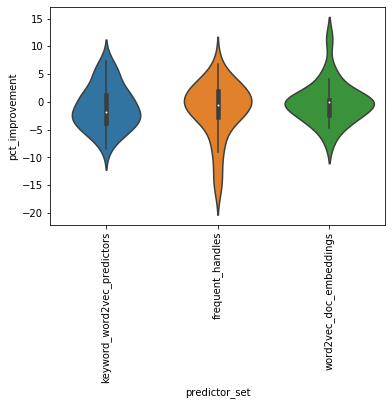

In [255]:
txt = open('currencies_1.txt', 'r')
lines = txt.readlines()

classifiers, regressors = get_model_performance(lines)
regressors, plot = get_regressor_violin(regressors)
regressors.sort_values('pct_improvement', ascending=False)

In [225]:
bitcoin = regressors[regressors.response_set == '../miscdata/bitcoindata.delta.csv']
usd_cad = regressors[regressors.response_set == '../miscdata/usd_cad_exchangerate.delta.csv']
usd_rub = regressors[regressors.response_set == '../miscdata/usd_rub_exchangerate.delta.csv']

/home/priyav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


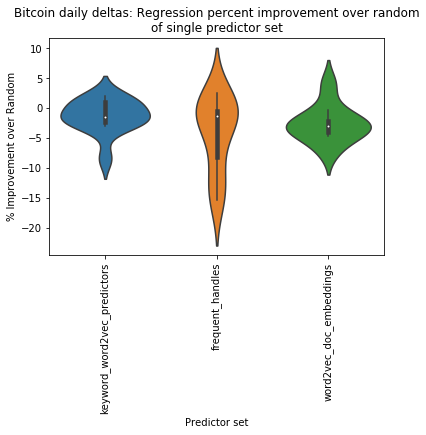

In [233]:
bitcoin_reg, plot = get_regressor_violin(bitcoin)
#plot.set_xticklabels([str(x).split("/")[-1].split(".")[0] for x in plot.get_xticklabels()], rotation=90)
plot.set_title('Bitcoin daily deltas: Regression percent improvement over random\nof single predictor set')
plot.set_ylabel('% Improvement over Random')
plot.set_xlabel('Predictor set')
plt.savefig('../../assets/img/bitcoin_1.single_predictor_set.regressor_pct_improvement.png')

/home/priyav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


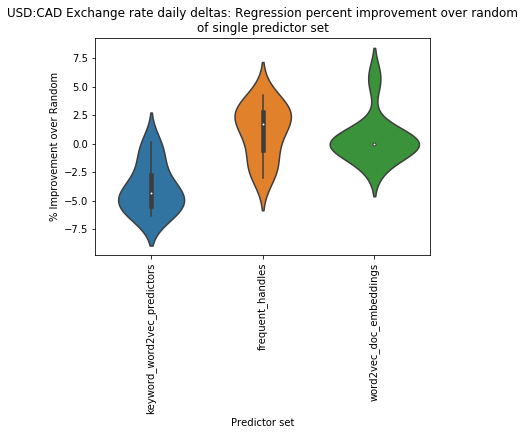

In [234]:
cad_reg, plot1 = get_regressor_violin(usd_cad)
#plot.set_xticklabels([str(x).split("/")[-1].split(".")[0] for x in plot.get_xticklabels()], rotation=90)
plot1.set_title('USD:CAD Exchange rate daily deltas: Regression percent improvement over random\nof single predictor set')
plot1.set_ylabel('% Improvement over Random')
plot1.set_xlabel('Predictor set')
plt.savefig('../../assets/img/usd_cad_1.single_predictor_set.regressor_pct_improvement.png')

/home/priyav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


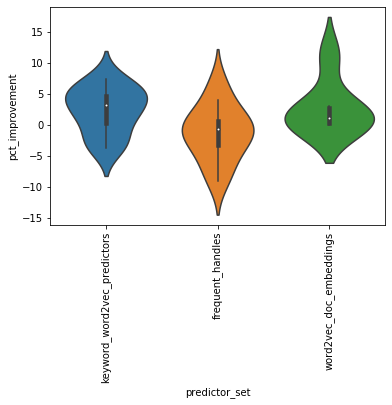

In [235]:
rub_reg, plot2 = get_regressor_violin(usd_rub)
#plot.set_xticklabels([str(x).split("/")[-1].split(".")[0] for x in plot.get_xticklabels()], rotation=90)
plot2.set_title('USD:RUB Exchange rate daily deltas: Regression percent improvement over random\nof single predictor set')
plot2.set_ylabel('% Improvement over Random')
plot2.set_xlabel('Predictor set')
plt.savefig('../../assets/img/usd_rub_1.single_predictor_set.regressor_pct_improvement.png')

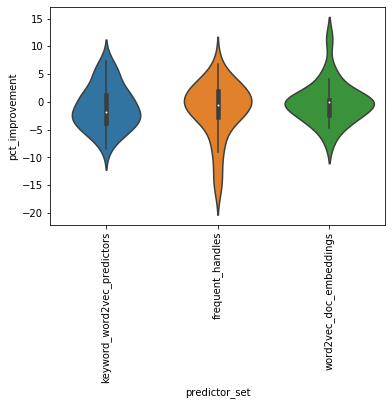

In [236]:
reg_all, _ = get_regressor_violin(regressors)

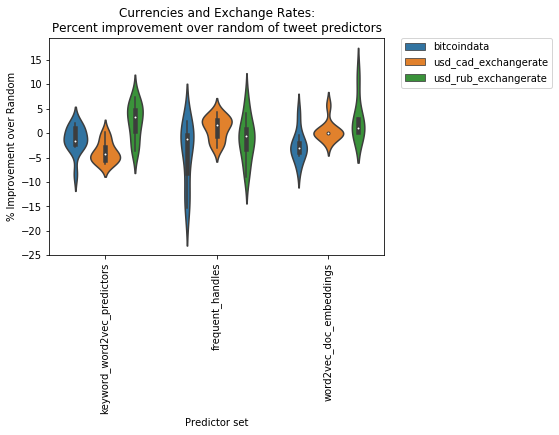

In [524]:
reg_all['label'] = [str(x).split("/")[-1].split(".")[0] for x in reg_all['response_set']]
plot_all = sns.violinplot(x='predictor_set', y='pct_improvement', hue='label', data=reg_all)
plot_all.set_xticklabels([str(x).split("/")[-1].split(".")[0] for x in plot_all.get_xticklabels()], rotation=90)
plot_all.set_ylabel('% Improvement over Random')
plot_all.set_xlabel('Predictor set')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plot_all.set_title("Currencies and Exchange Rates:\nPercent improvement over random of tweet predictors")


plt.savefig("../../assets/img/currencies_exchange_1.percent_improvement.png", bbox_inches = "tight")


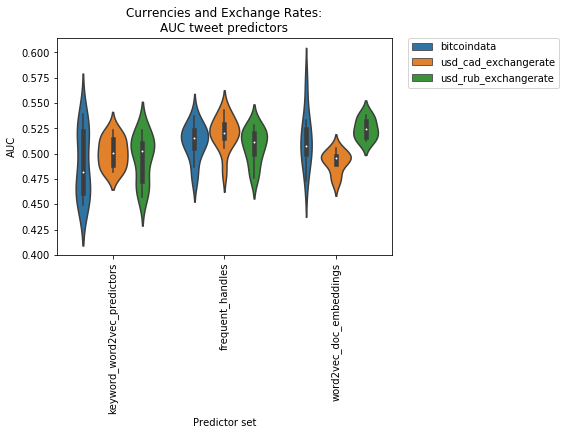

In [251]:
classifiers['label'] = [str(x).split("/")[-1].split(".")[0] for x in reg_all['response_set']]
plot_all = sns.violinplot(x='predictor_set', y='auc', hue='label', data=classifiers)
plot_all.set_xticklabels([str(x).split("/")[-1].split(".")[0] for x in plot_all.get_xticklabels()], rotation=90)
plot_all.set_ylabel('AUC')
plot_all.set_xlabel('Predictor set')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plot_all.set_title("Currencies and Exchange Rates:\nAUC tweet predictors")
plt.savefig("../../assets/img/currencies_exchange_1.auc.png")


### Models with 2 predictor sets (handles and embeddings)


Performance: tstat 18.624985428178395, pval 4.013195680361982e-34, training_loss 0.04538692740023482, validation_loss 0.02153734093784454, test_loss 0.1601294721831174, random5pc_loss 0.1624771496598802, random_mean 0.17382415662326525, random95pc_loss 0.18719406316443066
Performance: tstat 11.08152056963881, pval 4.862304678649998e-19, training_loss 0.04705957342551348, validation_loss 0.0198205124151181, test_loss 0.1832427080925994, random5pc_loss 0.1784282477665448, random_mean 0.19226403800971079, random95pc_loss 0.2076567636700127
Performance: tstat 12.795540683854652, pval 1.0512543186550314e-22, training_loss 0.04473873072074122, validation_loss 0.016932686683093105, test_loss 0.16096742766031755, random5pc_loss 0.15919699287164243, random_mean 0.1699236379223546, random95pc_loss 0.182264841447665
Performance: tstat 12.992150585371359, pval 4.058834762345486e-23, training_loss 0.025103866476197174, validation_loss 0.00896552824980855, test_loss 0.15143812966002568, random5pc_lo

<Figure size 432x288 with 0 Axes>

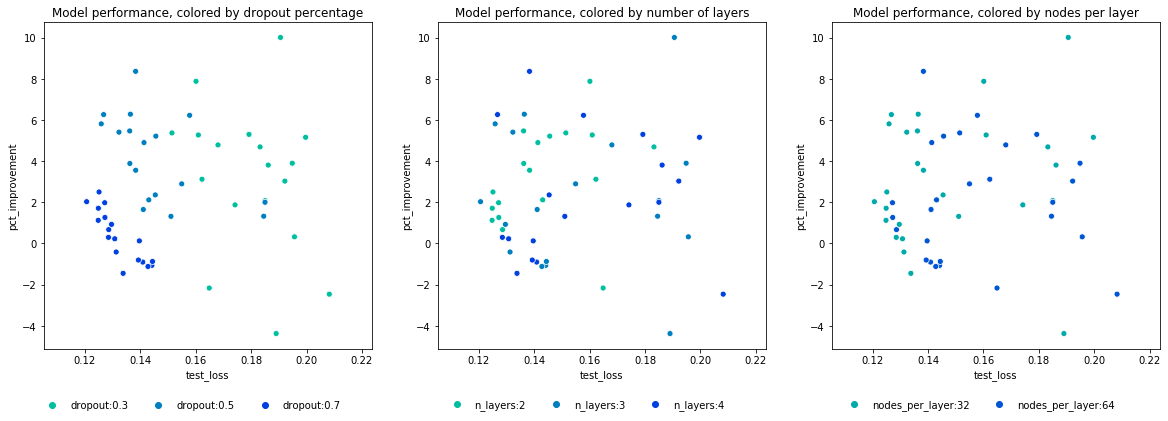

In [525]:
rub_2 = open('currency_2.txt', 'r')
lines = rub_2.readlines()

rub_classifiers, rub_regressors = get_model_performance(lines)
rub_reg, plot = get_regressor_violin(rub_regressors)
rub_reg.sort_values('pct_improvement', ascending=False)

plt.clf()

#sns.distplot(rub_regressors['pct_improvement'], kde=False,bins=20)

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax = ax.ravel()
for i in ['dropout', 'n_layers', 'nodes_per_layer', 'augment_n']:
    
    rub_reg[i] = ["{}:{}".format(i, x) for x in rub_reg[i]]
    
#china_reg['dropout'] = [str(x) for x in china_reg['dropout']]
sns.scatterplot(x='test_loss', y='pct_improvement', hue='dropout',data=rub_reg,palette="winter_r", ax=ax[0])
sns.scatterplot(x='test_loss', y='pct_improvement', hue='n_layers',data=rub_reg, palette="winter_r", ax=ax[1])
sns.scatterplot(x='test_loss', y='pct_improvement', hue='nodes_per_layer',data=rub_reg, palette="winter_r", ax=ax[2])
#sns.scatterplot(x='test_loss', y='pct_improvement', hue='augment_n',data=rub_reg, palette="winter_r", ax=ax[3])

ax[0].set_title("Model performance, colored by dropout percentage")
ax[1].set_title("Model performance, colored by number of layers")
ax[2].set_title("Model performance, colored by nodes per layer")
#ax[3].set_title("Model performance, colored by number of augmented datapoints")
for a in ax:
    handles, labels = a.get_legend_handles_labels()
    a.legend(loc='lower center', bbox_to_anchor= (0.45, -0.2), ncol=3, 
            borderaxespad=0, frameon=False, handles=handles[1:], labels=labels[1:])
    
plt.savefig('../../assets/img/rub_exchange_regression.model_architecture_analysis.png', bbox_inches = "tight")

In [392]:
rub_reg.query('n_layers=="n_layers:3" & nodes_per_layer=="nodes_per_layer:32" & dropout=="dropout:0.3" & augment_n')

,model_name,predictor_set,predictor_lookback,response_set,dropout,model_type,epochs,n_layers,nodes_per_layer,augment_n,tstat,pval,test_loss,random5pc_loss,random_mean,random95pc_loss,pct_improvement
6,model_723,../tweets/data/keyword_word2vec_predictors.by_...,1,../miscdata/usd_rub_exchangerate.delta.csv,dropout:0.3,regressor,250,n_layers:3,nodes_per_layer:32,augment_n:50,-8.938980,2.248843e-14,0.189036,0.166323,0.181114,0.196185,-4.374143
7,model_724,../tweets/data/keyword_word2vec_predictors.by_...,1,../miscdata/usd_rub_exchangerate.delta.csv,dropout:0.3,regressor,250,n_layers:3,nodes_per_layer:32,augment_n:100,4.679513,9.132584e-06,0.185022,0.175885,0.188956,0.202089,2.082049
8,model_725,../tweets/data/keyword_word2vec_predictors.by_...,1,../miscdata/usd_rub_exchangerate.delta.csv,dropout:0.3,regressor,250,n_layers:3,nodes_per_layer:32,augment_n:250,21.679831,2.233297e-39,0.190604,0.197001,0.211803,0.227458,10.009106


In [413]:
rub_reg.sort_values('test_loss')

,model_name,predictor_set,predictor_lookback,response_set,dropout,model_type,epochs,n_layers,nodes_per_layer,augment_n,tstat,pval,test_loss,random5pc_loss,random_mean,random95pc_loss,pct_improvement
42,model_759,../tweets/data/keyword_word2vec_predictors.by_...,1,../miscdata/usd_rub_exchangerate.delta.csv,dropout:0.7,regressor,250,n_layers:3,nodes_per_layer:32,augment_n:50,15.716719,1.183672e-28,0.120653,0.120535,0.123153,0.125641,2.029945
37,model_754,../tweets/data/keyword_word2vec_predictors.by_...,1,../miscdata/usd_rub_exchangerate.delta.csv,dropout:0.7,regressor,250,n_layers:2,nodes_per_layer:32,augment_n:100,6.522293,2.950829e-09,0.124835,0.122680,0.126256,0.129850,1.124905
36,model_753,../tweets/data/keyword_word2vec_predictors.by_...,1,../miscdata/usd_rub_exchangerate.delta.csv,dropout:0.7,regressor,250,n_layers:2,nodes_per_layer:32,augment_n:50,10.258344,2.990194e-17,0.124889,0.123395,0.127065,0.131153,1.712711
38,model_755,../tweets/data/keyword_word2vec_predictors.by_...,1,../miscdata/usd_rub_exchangerate.delta.csv,dropout:0.7,regressor,250,n_layers:2,nodes_per_layer:32,augment_n:250,13.421457,5.151070e-24,0.125137,0.124038,0.128349,0.132171,2.502241
25,model_742,../tweets/data/keyword_word2vec_predictors.by_...,1,../miscdata/usd_rub_exchangerate.delta.csv,dropout:0.5,regressor,250,n_layers:3,nodes_per_layer:32,augment_n:100,18.545117,5.591198e-34,0.125929,0.126540,0.133699,0.140332,5.811556
30,model_747,../tweets/data/keyword_word2vec_predictors.by_...,1,../miscdata/usd_rub_exchangerate.delta.csv,dropout:0.5,regressor,250,n_layers:4,nodes_per_layer:32,augment_n:50,16.926767,5.506468e-31,0.126785,0.128335,0.135254,0.144154,6.261743
41,model_758,../tweets/data/keyword_word2vec_predictors.by_...,1,../miscdata/usd_rub_exchangerate.delta.csv,dropout:0.7,regressor,250,n_layers:2,nodes_per_layer:64,augment_n:250,9.730035,4.246359e-16,0.127175,0.125200,0.129745,0.133385,1.980505
39,model_756,../tweets/data/keyword_word2vec_predictors.by_...,1,../miscdata/usd_rub_exchangerate.delta.csv,dropout:0.7,regressor,250,n_layers:2,nodes_per_layer:64,augment_n:50,7.602985,1.683512e-11,0.127256,0.125274,0.128885,0.132187,1.264521
50,model_767,../tweets/data/keyword_word2vec_predictors.by_...,1,../miscdata/usd_rub_exchangerate.delta.csv,dropout:0.7,regressor,250,n_layers:4,nodes_per_layer:32,augment_n:250,1.945566,5.454301e-02,0.128537,0.126192,0.128922,0.132055,0.298821
40,model_757,../tweets/data/keyword_word2vec_predictors.by_...,1,../miscdata/usd_rub_exchangerate.delta.csv,dropout:0.7,regressor,250,n_layers:2,nodes_per_layer:64,augment_n:100,3.128751,2.306390e-03,0.128626,0.125388,0.129499,0.134214,0.674265


Performance: tstat 9.670160795393041, pval 5.736664620689416e-16, training_loss 0.057890106003933135, validation_loss 0.014102075317139461, test_loss 0.5577903057155676, random5pc_loss 0.5473883152008057, random_mean 0.5779956086301129, random95pc_loss 0.6171126555217028
Performance: tstat 25.534638914743482, pval 2.3568222621898088e-45, training_loss 0.028421336190464108, validation_loss 0.0013608761492602927, test_loss 0.4932999399230674, random5pc_loss 0.5094755108701888, random_mean 0.532503381542098, random95pc_loss 0.5592984934156439
Performance: tstat 29.401835234226535, pval 1.0234740125010919e-50, training_loss 0.05810122448639491, validation_loss 0.013448841167520532, test_loss 0.5511687479044439, random5pc_loss 0.5759752394875031, random_mean 0.6039324494238033, random95pc_loss 0.6324946012598045
Performance: tstat 37.36367082612035, pval 3.598907458378223e-60, training_loss 0.06658673596776006, validation_loss 0.010372388148645247, test_loss 0.6530613615950932, random5pc_lo

<Figure size 432x288 with 0 Axes>

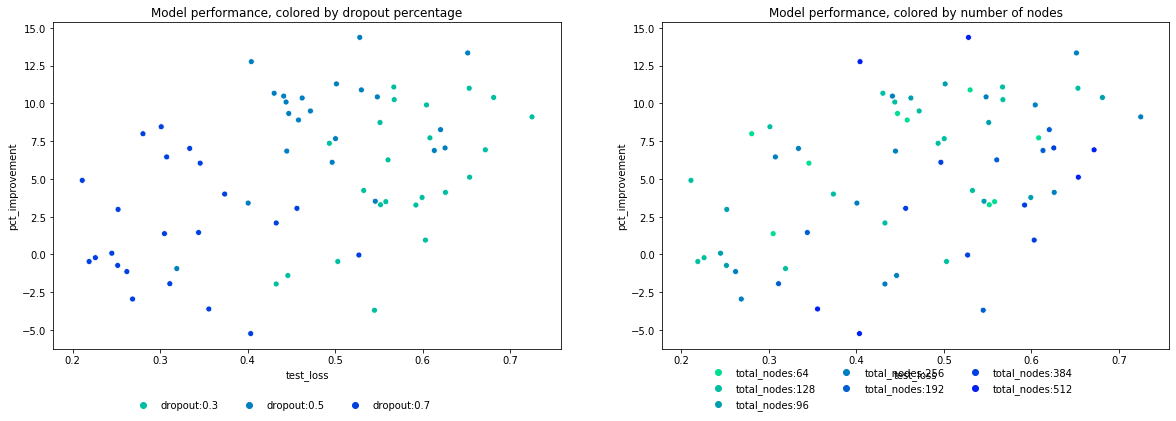

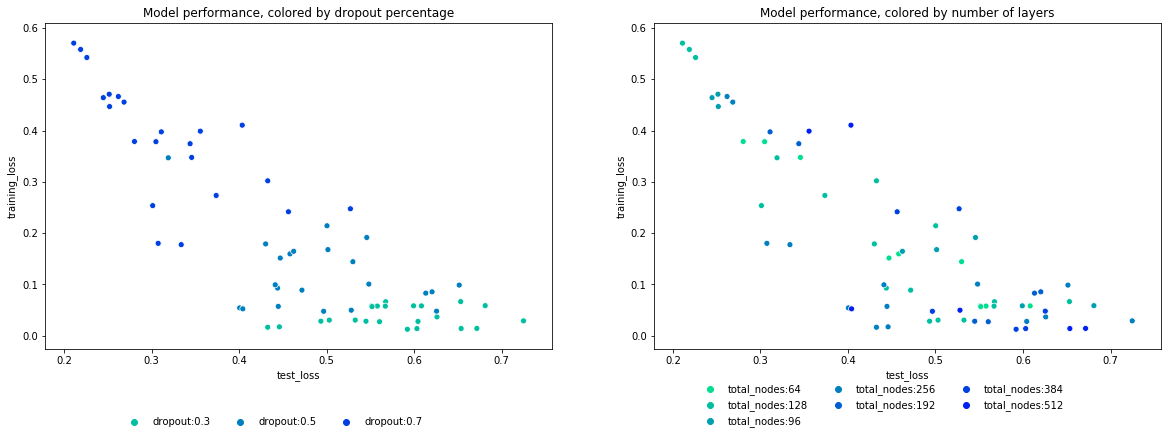

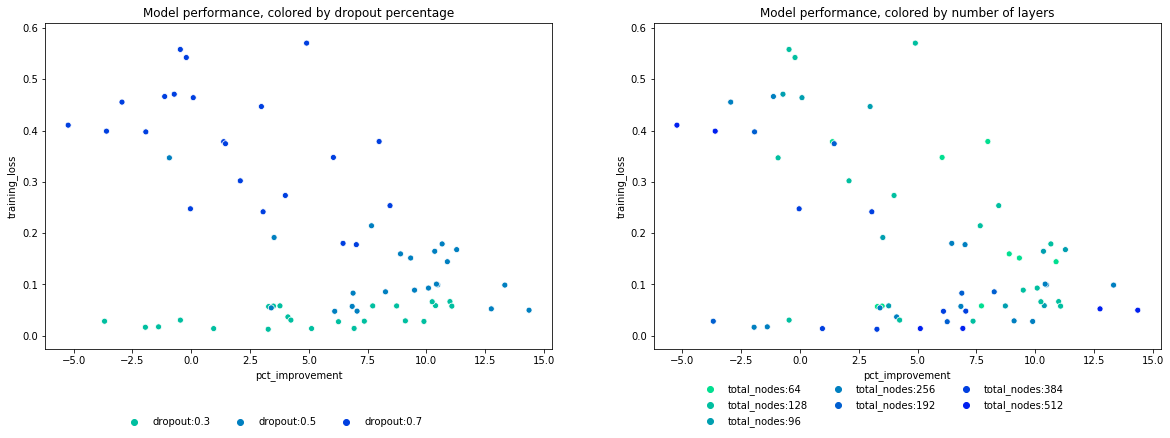

In [529]:
chinese_2 = open('chinese_stocks_3.txt', 'r')
lines = chinese_2.readlines()

china_class, china_reg = get_model_performance(lines)
china_reg, plot = get_regressor_violin(china_reg)
china_reg.sort_values('pct_improvement', ascending=False)
china_reg['total_nodes'] = china_reg['n_layers']*china_reg['nodes_per_layer']

plt.clf()

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()
for i in ['dropout','augment_n', 'total_nodes']:
    
    china_reg[i] = ["{}:{}".format(i, x) for x in china_reg[i]]
    
    
#china_reg['dropout'] = [str(x) for x in china_reg['dropout']]
sns.scatterplot(x='test_loss', y='pct_improvement', hue='dropout',data=china_reg,palette="winter_r", ax=ax[0])
sns.scatterplot(x='test_loss', y='pct_improvement', hue='total_nodes',data=china_reg, palette="winter_r", ax=ax[1])
#sns.scatterplot(x='test_loss', y='pct_improvement', hue='nodes_per_layer',data=china_reg, palette="winter_r", ax=ax[2])

ax[0].set_title("Model performance, colored by dropout percentage")
ax[1].set_title("Model performance, colored by number of nodes")
#ax[2].set_title("Model performance, colored by nodes per layer")

for a in ax:
    handles, labels = a.get_legend_handles_labels()
    a.legend(loc='lower center', bbox_to_anchor= (0.45, -0.2), ncol=3, 
            borderaxespad=0, frameon=False, handles=handles[1:], labels=labels[1:])

plt.savefig('../../assets/img/china_stock_regression.model_architecture_analysis.png')


# now plot the training loss vs test loss
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()
sns.scatterplot(x='test_loss', y='training_loss', hue='dropout',data=china_reg,palette="winter_r", ax=ax[0])
sns.scatterplot(x='test_loss', y='training_loss', hue='total_nodes',data=china_reg, palette="winter_r", ax=ax[1])
#sns.scatterplot(x='test_loss', y='training_loss', hue='nodes_per_layer',data=china_reg, palette="winter_r", ax=ax[2])

ax[0].set_title("Model performance, colored by dropout percentage")
ax[1].set_title("Model performance, colored by number of layers")
#ax[2].set_title("Model performance, colored by nodes per layer")

for a in ax:
    handles, labels = a.get_legend_handles_labels()
    a.legend(loc='lower center', bbox_to_anchor= (0.45, -0.25), ncol=3, 
            borderaxespad=0, frameon=False, handles=handles[1:], labels=labels[1:])

plt.savefig('../../assets/img/china_stock_regression.model_architecture_test_train_analysis.png', bbox_inches='tight')

# now plot the training loss vs test loss
fig, ax = plt.subplots(1,2, figsize=(20, 6))
ax = ax.ravel()
sns.scatterplot(x='pct_improvement', y='training_loss', hue='dropout',data=china_reg,palette="winter_r", ax=ax[0])
sns.scatterplot(x='pct_improvement', y='training_loss', hue='total_nodes',data=china_reg, palette="winter_r", ax=ax[1])
#sns.scatterplot(x='pct_improvement', y='training_loss', hue='nodes_per_layer',data=china_reg, palette="winter_r", ax=ax[2])

ax[0].set_title("Model performance, colored by dropout percentage")
ax[1].set_title("Model performance, colored by number of layers")
#ax[2].set_title("Model performance, colored by nodes per layer")

for a in ax:
    handles, labels = a.get_legend_handles_labels()
    a.legend(loc='lower center', bbox_to_anchor= (0.45, -0.25), ncol=3, 
            borderaxespad=0, frameon=False, handles=handles[1:], labels=labels[1:])

plt.savefig('../../assets/img/china_stock_regression.model_architecture_pct_improve_train_analysis.png', bbox_inches='tight')

In [465]:
# now look at the improvement gains in test loss and pct improvement by augmentation
china_base_plus = china_reg.query('n_layers=="n_layers:3" & nodes_per_layer=="nodes_per_layer:32" & dropout=="dropout:0.3"')[['augment_n', 'pct_improvement', 'test_loss', 'validation_loss', 'training_loss']]
china_base_plus['augment_n'] = [int(s.split(":")[1]) for s in china_base_plus.augment_n]
china_base_plus = china_base_plus.sort_values('augment_n')


plt.savefig('../../assets/img/augment_n_chinese.png')
china_base_plus

china_reg['diff'] = china_reg['test_loss'] - china_reg['training_loss']
china_reg.sort_values('diff')

,model_name,predictor_set,predictor_lookback,response_set,dropout,model_type,epochs,n_layers,nodes_per_layer,augment_n,tstat,pval,training_loss,validation_loss,test_loss,random5pc_loss,random_mean,random95pc_loss,pct_improvement,diff
12,model_660,../tweets/data/keyword_word2vec_predictors.by_...,5,../stocks/log_adj_chinese_combo.csv,dropout:0.7,regressor,500,n_layers:4,nodes_per_layer:32,augment_n:500,24.607096,5.607387e-44,0.570395,0.288958,0.210969,0.214100,0.221856,0.228208,4.907269,-0.359426
62,model_712,../tweets/data/keyword_word2vec_predictors.by_...,5,../stocks/log_adj_chinese_combo.csv,dropout:0.7,regressor,250,n_layers:4,nodes_per_layer:32,augment_n:100,-5.201230,1.069678e-06,0.558088,0.278336,0.218826,0.214645,0.217811,0.221075,-0.465778,-0.339262
61,model_711,../tweets/data/keyword_word2vec_predictors.by_...,5,../stocks/log_adj_chinese_combo.csv,dropout:0.7,regressor,250,n_layers:4,nodes_per_layer:32,augment_n:50,-1.278603,2.040261e-01,0.542337,0.319703,0.225960,0.219500,0.225484,0.231475,-0.211214,-0.316377
55,model_705,../tweets/data/keyword_word2vec_predictors.by_...,5,../stocks/log_adj_chinese_combo.csv,dropout:0.7,regressor,250,n_layers:3,nodes_per_layer:32,augment_n:50,1.148447,2.535514e-01,0.464081,0.232790,0.244757,0.241690,0.244964,0.247847,0.084747,-0.219324
11,model_657,../tweets/data/keyword_word2vec_predictors.by_...,5,../stocks/log_adj_chinese_combo.csv,dropout:0.7,regressor,500,n_layers:3,nodes_per_layer:32,augment_n:500,-7.815546,5.948537e-12,0.470816,0.226327,0.251495,0.246180,0.249688,0.253459,-0.723930,-0.219320
64,model_714,../tweets/data/keyword_word2vec_predictors.by_...,5,../stocks/log_adj_chinese_combo.csv,dropout:0.7,regressor,250,n_layers:4,nodes_per_layer:64,augment_n:100,-11.767292,1.616275e-20,0.466362,0.310612,0.261937,0.254614,0.259009,0.263172,-1.130399,-0.204425
56,model_706,../tweets/data/keyword_word2vec_predictors.by_...,5,../stocks/log_adj_chinese_combo.csv,dropout:0.7,regressor,250,n_layers:3,nodes_per_layer:32,augment_n:100,21.960057,7.778325e-40,0.446782,0.203021,0.251912,0.254357,0.259658,0.265590,2.983360,-0.194870
63,model_713,../tweets/data/keyword_word2vec_predictors.by_...,5,../stocks/log_adj_chinese_combo.csv,dropout:0.7,regressor,250,n_layers:4,nodes_per_layer:64,augment_n:50,-17.994333,5.624878e-33,0.455420,0.359323,0.268456,0.253899,0.260770,0.268070,-2.947303,-0.186964
49,model_699,../tweets/data/keyword_word2vec_predictors.by_...,5,../stocks/log_adj_chinese_combo.csv,dropout:0.7,regressor,250,n_layers:2,nodes_per_layer:32,augment_n:50,33.476957,8.616456e-56,0.378639,0.183255,0.280354,0.292935,0.304706,0.317021,7.992164,-0.098286
57,model_707,../tweets/data/keyword_word2vec_predictors.by_...,5,../stocks/log_adj_chinese_combo.csv,dropout:0.7,regressor,250,n_layers:3,nodes_per_layer:64,augment_n:50,-12.264396,1.400535e-21,0.397405,0.215769,0.311029,0.296413,0.305132,0.313031,-1.932874,-0.086376


<Figure size 432x288 with 0 Axes>

Chinese stocks with fewer lookback predictors for word2vec

Performance: tstat 53.373026504123715, pval 9.014894950231033e-75, training_loss 0.3957545999546987, validation_loss 0.2928365555390299, test_loss 0.3234921508458815, random5pc_loss 0.37939771809763284, random_mean 0.40909214012087863, random95pc_loss 0.43808095004449044
Performance: tstat 44.31067859009138, pval 4.321126315066356e-67, training_loss 0.46220003095377177, validation_loss 0.3855801277546921, test_loss 0.2707888034201974, random5pc_loss 0.3095547738007859, random_mean 0.33533019034211703, random95pc_loss 0.35873585602419955
Performance: tstat 36.89754779240508, pval 1.1484598808297748e-59, training_loss 0.34701321090034004, validation_loss 0.25221083717833026, test_loss 0.30187354559348667, random5pc_loss 0.33763887899082035, random_mean 0.36032181275922914, random95pc_loss 0.38746613548416975
Performance: tstat 37.00431842005822, pval 8.794197651897487e-60, training_loss 0.39952894350627266, validation_loss 0.3293019912277737, test_loss 0.22586930759066828, random5pc_loss

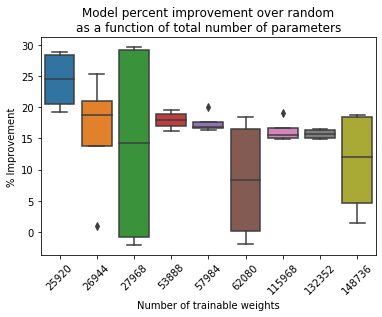

In [527]:
txt = open('china_stocks_4.txt', 'r')
lines = txt.readlines()

_, reg = get_model_performance(lines)
reg, plot = get_regressor_violin(reg)
plt.clf()
i = 777
reg['total_params'] = [i*x + (y-1)*x**2 + x for x, y in zip(reg['nodes_per_layer'],reg['n_layers'])]
reg['dropout'] = ['dropout:{}'.format(d) for d in reg.dropout]
# look at total parameters
plot = sns.boxplot(x='total_params', y='pct_improvement', data=reg)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plt.ylabel('% Improvement')
plt.xlabel('Number of trainable weights')
plt.title('Model percent improvement over random\nas a function of total number of parameters')
plt.savefig('../../assets/img/params_percent_improvement.png', bbox_inches='tight')




Performance: tstat 21.36110782934266, pval 7.493380559700269e-39, training_loss 0.00330742701925536, validation_loss 0.0010466340933113782, test_loss 0.5995143120154054, random5pc_loss 0.6127920772077338, random_mean 0.6548704549154206, random95pc_loss 0.6993348101423823
Performance: tstat 28.033650208284477, pval 6.93873519235471e-49, training_loss 0.06918010409341238, validation_loss 0.01779280922593326, test_loss 0.4633085368062919, random5pc_loss 0.48638542991644923, random_mean 0.528900913308661, random95pc_loss 0.5635932664989162
Performance: tstat 36.263387187783465, pval 5.684011520727452e-59, training_loss 0.20424188816941755, validation_loss 0.13744175616865173, test_loss 0.2931307255168686, random5pc_loss 0.3257148604932185, random_mean 0.3488102649499797, random95pc_loss 0.37768135011827986
Performance: tstat 48.870406512736736, pval 4.045025577323974e-71, training_loss 0.3095219389608073, validation_loss 0.21984433224354177, test_loss 0.3771920817584958, random5pc_loss 0.4

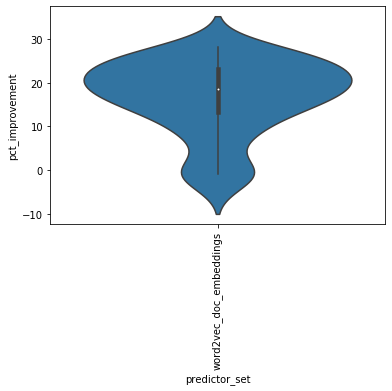

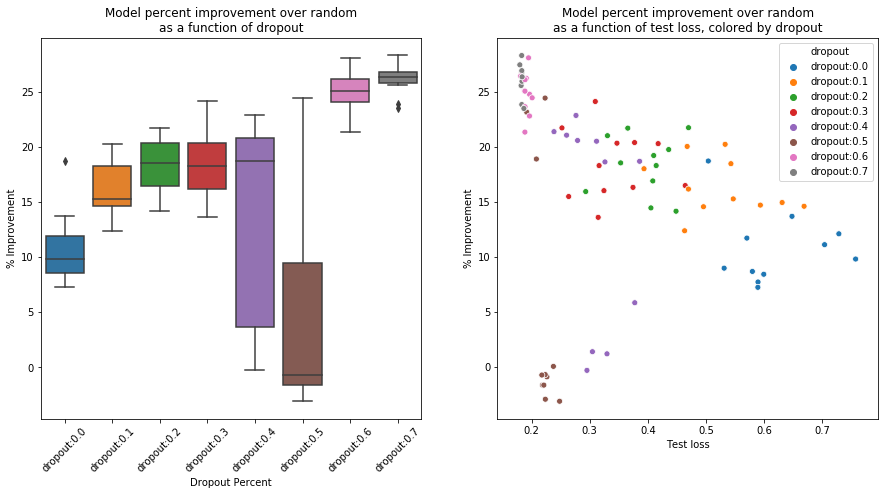

In [528]:
# dropout analysis for chinese stocks
txt = open('china_stocks_5.txt', 'r')
lines = txt.readlines()

_, reg = get_model_performance(lines)
reg, plot = get_regressor_violin(reg)
reg['dropout'] = ["dropout:{}".format(d) for d in reg.dropout]
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
plot = sns.boxplot(x='dropout', y='pct_improvement', data=reg, ax=ax[0])
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
ax[0].set_ylabel('% Improvement')
ax[0].set_xlabel('Dropout Percent')
ax[0].set_title('Model percent improvement over random\nas a function of dropout')
#plt.savefig('../../assets/img/dropout_percent_improvement.png')

plot = sns.scatterplot(x='test_loss', y='pct_improvement', hue='dropout', data=reg, ax=ax[1])
#plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
ax[1].set_ylabel('% Improvement')
ax[1].set_xlabel('Test loss')
ax[1].set_title('Model percent improvement over random\nas a function of test loss, colored by dropout')
plt.savefig('../../assets/img/test_loss_dropout_percent_improvement.png', bbox_inches='tight')


In [534]:
reg.sort_values('pct_improvement', ascending=False)
reg['test_val_diff'] = np.abs(reg['test_loss'] - reg['validation_loss'])
reg.sort_values('validation_loss')

,model_name,predictor_set,predictor_lookback,response_set,dropout,model_type,epochs,n_layers,nodes_per_layer,augment_n,...,tstat,pval,training_loss,validation_loss,test_loss,random5pc_loss,random_mean,random95pc_loss,pct_improvement,test_val_diff
48,model_855,../tweets/data/word2vec_doc_embeddings.by_date...,0,../stocks/log_adj_chinese_combo.csv,dropout:0.0,regressor,250,4,32,250,...,17.515295,4.321554e-32,0.002477,0.000739,0.589601,0.595522,0.639127,0.688959,7.748999,0.588862
56,model_863,../tweets/data/word2vec_doc_embeddings.by_date...,0,../stocks/log_adj_chinese_combo.csv,dropout:0.0,regressor,250,4,32,250,...,24.078353,3.550526e-43,0.002366,0.000751,0.757581,0.782983,0.840222,0.897519,9.835593,0.756830
40,model_847,../tweets/data/word2vec_doc_embeddings.by_date...,0,../stocks/log_adj_chinese_combo.csv,dropout:0.0,regressor,250,4,32,250,...,36.093763,8.753948e-59,0.002020,0.000800,0.704185,0.751085,0.792458,0.833466,11.139195,0.703385
32,model_839,../tweets/data/word2vec_doc_embeddings.by_date...,0,../stocks/log_adj_chinese_combo.csv,dropout:0.0,regressor,250,4,32,250,...,43.216280,4.555126e-66,0.002824,0.000849,0.504092,0.574568,0.620318,0.661817,18.736462,0.503244
72,model_879,../tweets/data/word2vec_doc_embeddings.by_date...,0,../stocks/log_adj_chinese_combo.csv,dropout:0.0,regressor,250,4,32,250,...,30.101233,1.258908e-51,0.003673,0.000867,0.728745,0.782709,0.829323,0.884461,12.127660,0.727878
16,model_823,../tweets/data/word2vec_doc_embeddings.by_date...,0,../stocks/log_adj_chinese_combo.csv,dropout:0.0,regressor,250,4,32,250,...,24.124350,3.020414e-43,0.002901,0.000899,0.579920,0.597589,0.635241,0.673900,8.708707,0.579021
80,model_887,../tweets/data/word2vec_doc_embeddings.by_date...,0,../stocks/log_adj_chinese_combo.csv,dropout:0.0,regressor,250,4,32,250,...,26.572447,7.506337e-47,0.002910,0.000950,0.570419,0.608824,0.646274,0.695567,11.737248,0.569469
8,model_815,../tweets/data/word2vec_doc_embeddings.by_date...,0,../stocks/log_adj_chinese_combo.csv,dropout:0.0,regressor,250,4,32,250,...,39.552136,1.824121e-62,0.002009,0.000971,0.648101,0.710871,0.751108,0.789431,13.714103,0.647130
0,model_807,../tweets/data/word2vec_doc_embeddings.by_date...,0,../stocks/log_adj_chinese_combo.csv,dropout:0.0,regressor,250,4,32,250,...,21.361108,7.493381e-39,0.003307,0.001047,0.599514,0.612792,0.654870,0.699335,8.452991,0.598468
64,model_871,../tweets/data/word2vec_doc_embeddings.by_date...,0,../stocks/log_adj_chinese_combo.csv,dropout:0.0,regressor,250,4,32,250,...,17.855964,1.010649e-32,0.004153,0.001094,0.589363,0.595102,0.635547,0.685054,7.266903,0.588269
